In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

# Any results you write to the current directory are saved as output.

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
os.chdir('/kaggle/input/histopathologic-cancer-detection')
os.listdir()
test_files=os.listdir('test') # Name of the images of the test dataset

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.applications.resnet import ResNet50
from keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Dropout,Flatten,AvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,RMSprop,Adam
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA,LatentDirichletAllocation
import eli5

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
import pandas as pd
sample_submission = pd.read_csv("sample_submission.csv")
train_labels = pd.read_csv("train_labels.csv")
train_labels['label']=train_labels['label'].apply(lambda x:str(x))
train_labels['id']=train_labels['id'].apply(lambda x:str(x)+'.tif')

0    130908
1     89117
Name: label, dtype: int64


(array([0, 1]), <a list of 2 Text xticklabel objects>)

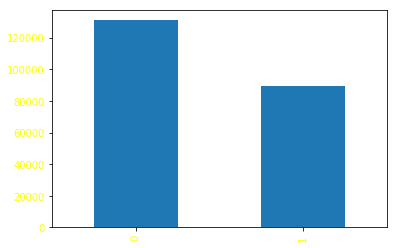

In [5]:
train_labels['label'].value_counts().plot(kind='bar')
print(train_labels['label'].value_counts())
plt.yticks(color='yellow')
plt.xticks(color='yellow')

In [ ]:
# The dataset is imbalanced. So we will check ADASYN or SMOTE

# Dataset Generator

In [6]:
%%time
train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.15)
test_datagen=ImageDataGenerator(rescale=1./255)
traindir='train'
testdir='test'
train=train_datagen.flow_from_dataframe(train_labels,directory=traindir,
                                        x_col='id',y_col='label',
                                        subset='training',
                                        target_size=(96,96),
                                        batch_size=64,class_mode='binary')

validation=train_datagen.flow_from_dataframe(train_labels,directory=traindir,
                                        x_col='id',y_col='label',
                                        subset='validation',
                                        target_size=(96,96),
                                        batch_size=64,class_mode='binary')

Found 187022 validated image filenames belonging to 2 classes.
Found 33003 validated image filenames belonging to 2 classes.
CPU times: user 8.59 s, sys: 10.8 s, total: 19.4 s
Wall time: 1min 56s


In [9]:
print(f"Length of the training dataset is {len(train)*64} ,validation {len(validation)*64} ,test {len(test_files)}")

Length of the training dataset is 187072 ,validation 33024 ,test 57458


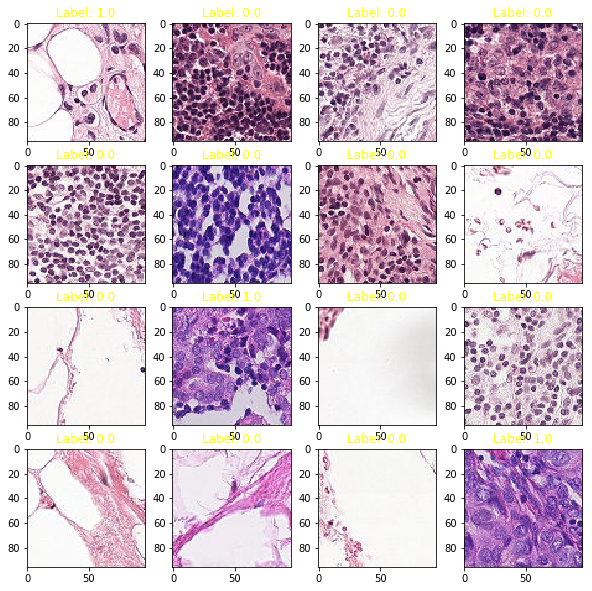

In [10]:
# Visualizing some examples
temp_img,temp_label=next(iter(train))
j=0
fig=plt.figure(figsize=(10,10))
for idx, img in enumerate(temp_img):
    if j==16:
        break
    j+=1
    ax = fig.add_subplot(4,4, idx+1)
    plt.imshow(img)
    lab = temp_label[idx]
    ax.set_title('Label: %s'%lab,color='yellow')

# Visualizing with T-Stochastic Neighbour Embedding

In [58]:
tsne=TSNE(n_components=2,init='pca')

In [64]:
%time
ims=[] # For Images
lbs=[] # For labels
for idx,batch in enumerate(train):
    image,label=batch
    image=[i.reshape(-1) for i in image]
    ims+=image
    for i in label:
        lbs.append(i)
    if len(ims)>1000:
        print(len(ims))
        break

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
1024


CPU times: user 1min 33s, sys: 577 ms, total: 1min 34s
Wall time: 1min 33s


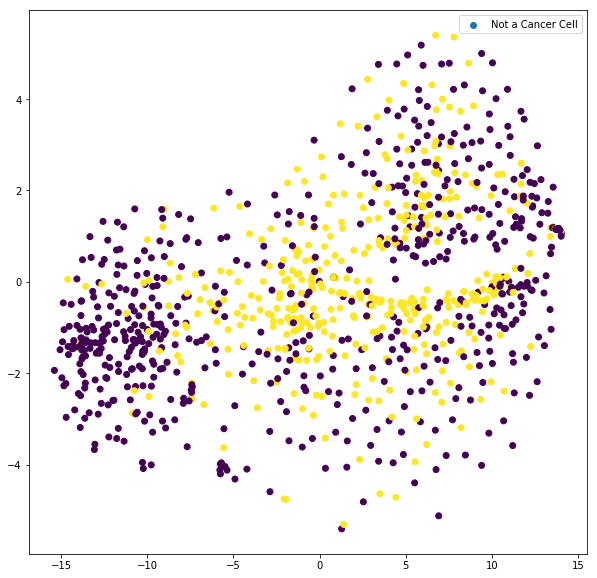

In [65]:
%%time
plt.figure(figsize=(10,10))
ims=tsne.fit_transform(ims)
plt.scatter(ims[:,0],ims[:,1],c=lbs)
plt.legend(["Not a Cancer Cell","Cancer Cell"])

In [ ]:
# So we can see how the classes are clustered and how one class actually

In [38]:
classifier=Sequential()

# Conv1 Layer
classifier.add(Conv2D(16,(3,3),strides=(1,1),input_shape=(96,96,3),activation='relu'))
classifier.add(Conv2D(16,(3,3),activation='relu'))
classifier.add(MaxPool2D(2))
classifier.add(BatchNormalization())

# Conv2 Layer
classifier.add(Conv2D(32,(3,3),strides=1,activation='relu'))
classifier.add(Conv2D(32,(3,3),strides=1,activation='relu'))
classifier.add(MaxPool2D(2))
classifier.add(BatchNormalization())


# Conv3 Layer
classifier.add(Conv2D(64,(3,3),strides=1,activation='relu'))
classifier.add(Conv2D(64,(3,3),strides=1,activation='relu'))
classifier.add(MaxPool2D(2))
classifier.add(BatchNormalization())


# Conv4 Layer
classifier.add(Conv2D(128,(3,3),strides=1,activation='relu'))
classifier.add(Conv2D(128,(3,3),strides=1,activation='relu'))
classifier.add(MaxPool2D(2))
classifier.add(BatchNormalization())


# Dense Layer
classifier.add(Flatten())
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=64,activation='relu'))
classifier.add(Dense(units=32,activation='relu'))
classifier.add(Dense(units=1,activation='sigmoid'))

classifier.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [39]:
classifier.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 92, 92, 16)        2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 46, 46, 16)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 46, 46, 16)        64        
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 44, 44, 32)        4640      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 21, 21, 32)       

In [40]:
history=classifier.fit_generator(train,epochs=9,validation_data=validation)

Epoch 1/9
2923/2923 [==============================] - 256s 87ms/step - loss: 0.3804 - accuracy: 0.8354 - val_loss: 0.3447 - val_accuracy: 0.8144
Epoch 2/9
2923/2923 [==============================] - 249s 85ms/step - loss: 0.3136 - accuracy: 0.8688 - val_loss: 0.4591 - val_accuracy: 0.7831
Epoch 3/9
2923/2923 [==============================] - 251s 86ms/step - loss: 0.2708 - accuracy: 0.8895 - val_loss: 0.7074 - val_accuracy: 0.8122
Epoch 4/9
2923/2923 [==============================] - 254s 87ms/step - loss: 0.2490 - accuracy: 0.9004 - val_loss: 0.7545 - val_accuracy: 0.8100
Epoch 5/9
2923/2923 [==============================] - 256s 88ms/step - loss: 0.2360 - accuracy: 0.9068 - val_loss: 0.4623 - val_accuracy: 0.7539
Epoch 6/9
2923/2923 [==============================] - 246s 84ms/step - loss: 0.2226 - accuracy: 0.9123 - val_loss: 0.2870 - val_accuracy: 0.8670
Epoch 7/9
2923/2923 [==============================] - 248s 85ms/step - loss: 0.2189 - accuracy: 0.9140 - val_loss: 0.2836 -

In [50]:
def occlusion_analysis(image,label,occluding_size,occluding_pixel,occluding_stride):
    """ Convnet Visualization """
    
    
    height,width,_=image.shape
    image=np.expand_dims(image,axis=0)
    out=classifier.predict(image)
    
    # Setting up output height and output width
    
    output_height=int(np.floor((height-occluding_size)/occluding_stride+1))
    output_width=int(np.floor((width-occluding_size)/occluding_stride+1))
    heatmap=np.zeros((output_height,output_width))
    
    for h in range(output_height):
        for w in range(output_width):
            # Occluder region
            
            h_start=h*occluding_stride
            h_end=min(height,h_start+occluding_size)
            
            w_start=w*occluding_stride
            w_end=min(width,w_start+occluding_size)
            
            input_image=image.copy()
            
            input_image[:,h_start:h_end,w_start:w_end,:]=occluding_pixel
            
            predict=classifier.predict(input_image)
            
            heatmap[h,w]=predict
            
    f=plt.figure(figsize=(10,10))
    f.add_subplot(2,2,1)
    sns.heatmap(heatmap,xticklabels=True)
    f.add_subplot(2,2,3"]))
    plt.imshow(image[0])
    plt.title(label)
    plt.show()

In [51]:
y1,l1=next(iter(train))

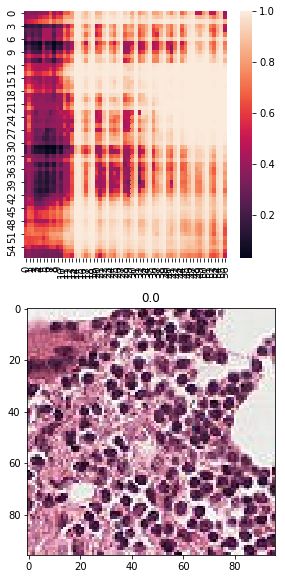

CPU times: user 13.7 s, sys: 1.18 s, total: 14.8 s
Wall time: 11.1 s


In [57]:
%%time
occlusion_analysis(y1[2],l1[2],occluding_size=40,occluding_pixel=2,occluding_stride=1)

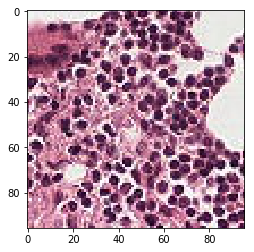

In [55]:
plt.imshow(y1[2])